# White Wine Quality Classification

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve

In [14]:
df = pd.read_csv('winequality-white.csv',sep=';')

In [15]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [17]:
df.head().isnull()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False


In [18]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Hedef Değişken Dağılımı

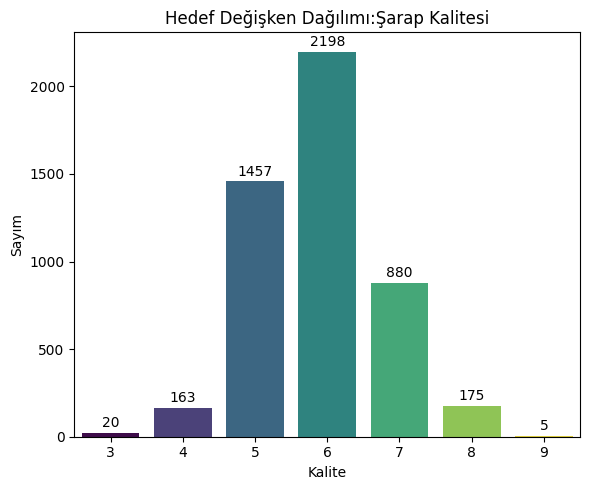

In [19]:
plt.figure(figsize=(6,5))
sns.countplot(data=df, x="quality",hue="quality",legend=False,palette="viridis")
plt.title("Hedef Değişken Dağılımı:Şarap Kalitesi")
plt.xlabel("Kalite")
plt.ylabel("Sayım")

for i in plt.gca().containers:
    plt.gca().bar_label(i, padding=2)

plt.tight_layout()
plt.show()

# Korelasyon Analizi

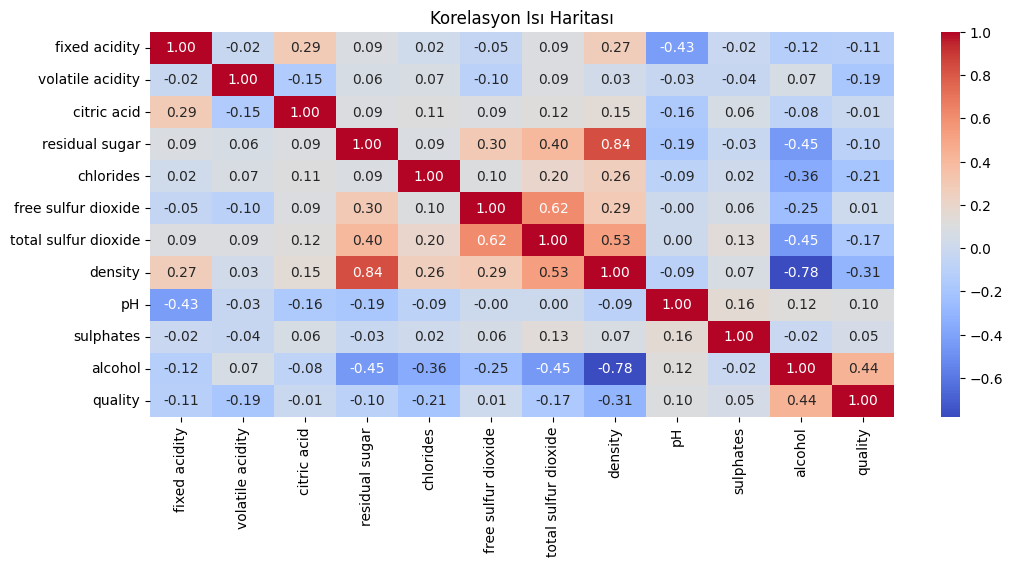

In [24]:
plt.figure(figsize=(12,5))
data_corr = df.corr()  # DataFrame'in korelasyon matrisini oluştur
sns.heatmap(data_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korelasyon Isı Haritası")
plt.show()

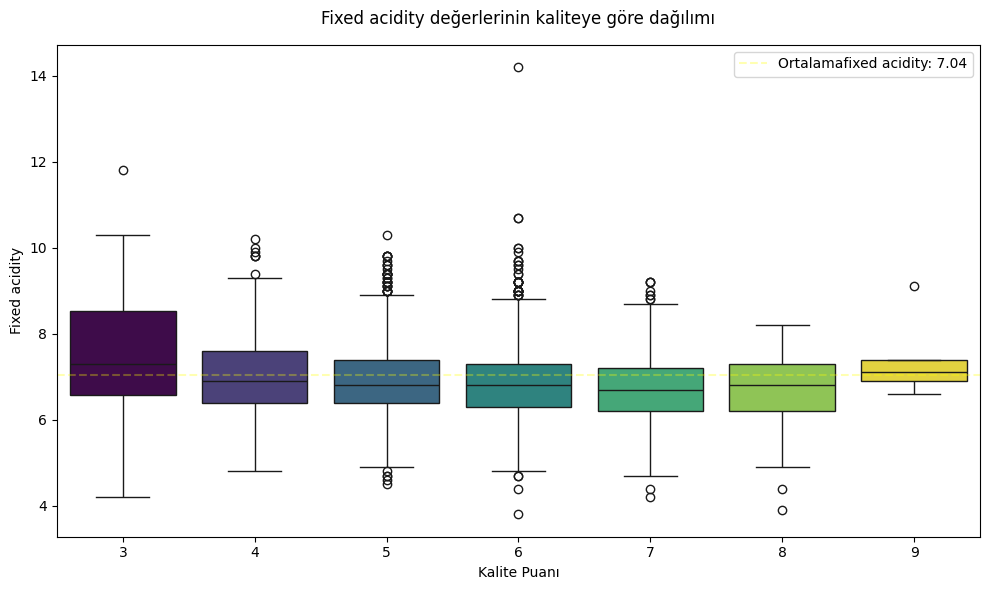

In [25]:
for feature in df.columns[:1]:
    plt.figure(figsize=(10,6))
    sns.boxplot(x="quality",y=feature,data=df,hue="quality",legend=False,palette="viridis")
    plt.title(f"{feature.capitalize()} değerlerinin kaliteye göre dağılımı",pad=15)
    plt.xlabel("Kalite Puanı")
    plt.ylabel(feature.capitalize())
    means = df.groupby("quality")[feature].mean()
    plt.axhline(y=means.mean(),color='yellow',linestyle='--',alpha=0.3,label=f"Ortalama{feature}: {means.mean():.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# IQR ile Aykırı Değer Tespiti ve Temizleme yöntemi

In [26]:
Q1 = df.quantile(0.25) # İlk çeyreklik
Q3 = df.quantile(0.75) # Üçüncü çeyreklik
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

In [28]:
cleaned_df = df[((df < alt_sinir) | (df > ust_sinir)).any(axis=1)]
print(df.shape)
print(cleaned_df.shape)

(4898, 12)
(1040, 12)


In [29]:
cleaned_df = df.copy() # Verisetini güvenli bir şekilde kopyalama 
# İkili sınıflandırma için kalite değerlerini dönüştür
cleaned_df.loc[:,"quality"] = cleaned_df["quality"].apply(lambda x: 1 if x >= 6 else 0)
print(cleaned_df["quality"].value_counts())
print(cleaned_df["quality"].value_counts(normalize=True).round(3) * 100)

quality
1    3258
0    1640
Name: count, dtype: int64
quality
1    66.5
0    33.5
Name: proportion, dtype: float64


In [33]:
X = cleaned_df.drop("quality",axis=1) # Özellikler
y = cleaned_df["quality"] # Hedef

# Özellik Ölçeklendirme

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Özellikleri standartize et

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=76)

Lojistik Regresyon ile Model Eğitme

In [37]:
log_model = LogisticRegression(random_state=76)
log_model.fit(X_train,y_train)
y_pred_log = log_model.predict(X_test)

Karar Ağaçları ile Model Eğitme

In [ ]:
tree_model = DecisionTreeClassifier(random_state=76) 
tree_model.fit(X_train,y_train)
y_pred_tree = tree_model.predict(X_test)

Random Forest ile Model Eğitme

In [49]:
rf_model = RandomForestClassifier(random_state=76,n_estimators=100) # n estimators karar ağaçları sayısına eşittir,default olarak genelde 100 olarak alınır
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)

# Performans Değerlendirme

In [50]:
def evulate_model(y_test,y_pred,model_name):
    print(model_name)
    print("\nKarışıklık Matrisi:")
    cm = confusion_matrix(y_test,y_pred) # Karışıklık matrisini hesapla
    sns.heatmap(cm,annot=True,fmt = "d",cmap = "Blues") # Karışıklık Matrisi Isı haritası
    plt.title(f"Karışıklık Matrisi: {model_name}")
    plt.xlabel("Tahmin Verileri")
    plt.ylabel("Gerçek Değerler")
    plt.show()

    # Sınıflandırma raporu
    print(classification_report(y_test,y_pred))

Lojistik Regresyon

Karışıklık Matrisi:


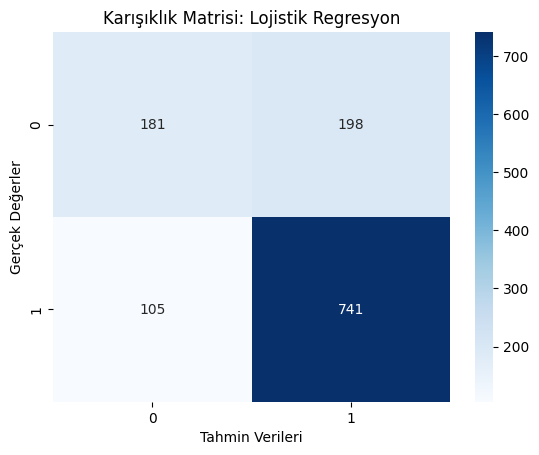

              precision    recall  f1-score   support

           0       0.63      0.48      0.54       379
           1       0.79      0.88      0.83       846

    accuracy                           0.75      1225
   macro avg       0.71      0.68      0.69      1225
weighted avg       0.74      0.75      0.74      1225

Karar Ağaçları

Karışıklık Matrisi:


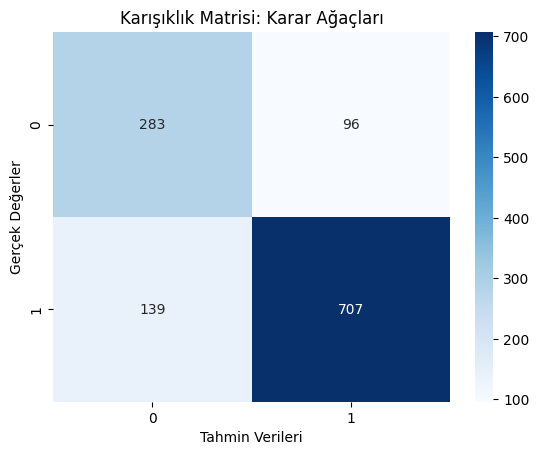

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       379
           1       0.88      0.84      0.86       846

    accuracy                           0.81      1225
   macro avg       0.78      0.79      0.78      1225
weighted avg       0.82      0.81      0.81      1225

Random Forest

Karışıklık Matrisi:


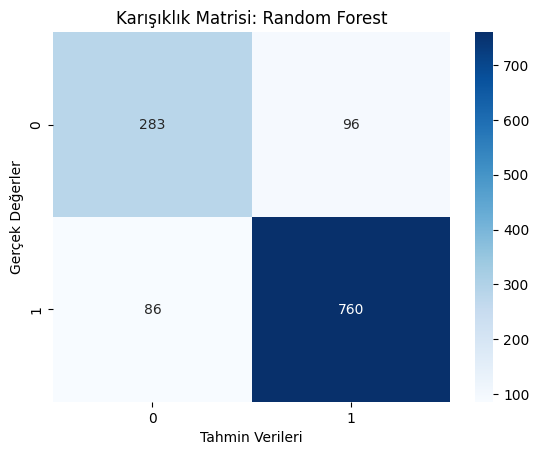

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       379
           1       0.89      0.90      0.89       846

    accuracy                           0.85      1225
   macro avg       0.83      0.82      0.82      1225
weighted avg       0.85      0.85      0.85      1225



In [51]:
evulate_model(y_test,y_pred_log, "Lojistik Regresyon")
evulate_model(y_test,y_pred_tree, "Karar Ağaçları")
evulate_model(y_test,y_pred_rf, "Random Forest")

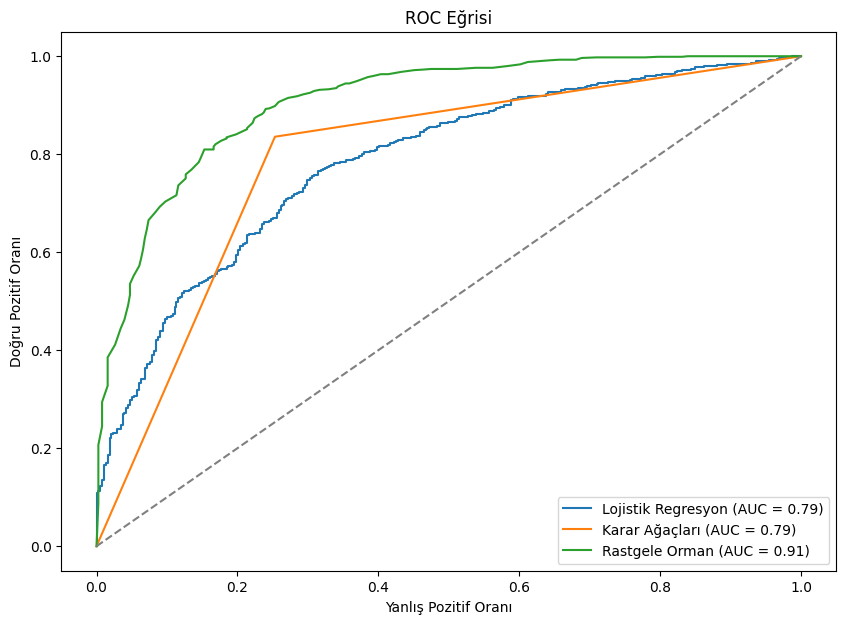

In [52]:
# Modellerin farklı eşiklerdeki performanslarını karşılaştırmak için ROC eğrisini çiz
plt.figure(figsize=(10, 7))
for model, pred, name in zip([log_model, tree_model, rf_model], [y_pred_log, y_pred_tree, y_pred_rf], ["Lojistik Regresyon", "Karar Ağaçları", "Rastgele Orman"]):
    try:
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])  # FPR ve TPR hesapla
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f})")  # ROC eğrisini çiz
    except AttributeError:
        print(f"{name} 'predict_proba' fonksiyonunu desteklemiyor.")
        continue

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Rasgele sınıflandırıcı için referans çizgisi
plt.title("ROC Eğrisi")
plt.xlabel("Yanlış Pozitif Oranı")
plt.ylabel("Doğru Pozitif Oranı")
plt.legend()
plt.show()
     

Sonuç
Tüm üç model değerlendirildikten sonra şu sonuçlara varılabilir:
- Lojistik Regresyon: Hızlı ve basit ancak karmaşık verilere iyi uyum sağlamayabilir.
- Karar Ağaçları: Aşırı uyum sağlama riski var; ayar yapılarak daha iyi performans elde edilebilir.
- Rastgele Orman: Üç model arasında en iyi genelleme ve performansa sahip.